In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/AMS.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,2.70,2.80,2.70,2.8,2.8,5600
1,1/3/2013,2.75,2.81,2.74,2.8,2.8,4500
2,1/4/2013,2.80,2.80,2.80,2.8,2.8,0
3,1/7/2013,2.75,2.75,2.70,2.7,2.7,400
4,1/8/2013,2.70,2.70,2.60,2.6,2.6,500


In [3]:
from collections import deque
import random


class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 10
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: 9.479999.3, cost: 0.003073, total money: 9122.540000
epoch: 20, total rewards: 16.639998.3, cost: 0.003031, total money: 9072.759999
epoch: 30, total rewards: 54.539997.3, cost: 0.001958, total money: 9224.549997
epoch: 40, total rewards: 13.489997.3, cost: 0.001277, total money: 9350.189997
epoch: 50, total rewards: -32.030004.3, cost: 0.000907, total money: 9430.429997
epoch: 60, total rewards: -42.470003.3, cost: 0.000560, total money: 9528.459996
epoch: 70, total rewards: -49.070003.3, cost: 0.000312, total money: 9632.849998
epoch: 80, total rewards: -47.520003.3, cost: 0.000213, total money: 9679.719997
epoch: 90, total rewards: -50.110003.3, cost: 0.000152, total money: 9714.889997
epoch: 100, total rewards: -55.920003.3, cost: 0.000142, total money: 9717.849996
epoch: 110, total

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 11: buy 1 unit at price 2.320000, total balance 9997.680000
day 14, sell 1 unit at price 2.190000, investment -5.603443 %, total balance 9999.870000,
day 19: buy 1 unit at price 2.230000, total balance 9997.640000
day 20, sell 1 unit at price 2.250000, investment 0.896860 %, total balance 9999.890000,
day 30: buy 1 unit at price 2.250000, total balance 9997.640000
day 31, sell 1 unit at price 2.150000, investment -4.444440 %, total balance 9999.790000,
day 39: buy 1 unit at price 2.100000, total balance 9997.690000
day 40: buy 1 unit at price 2.100000, total balance 9995.590000
day 41, sell 1 unit at price 2.040000, investment -2.857140 %, total balance 9997.630000,
day 42: buy 1 unit at price 1.970000, total balance 9995.660000
day 43, sell 1 unit at price 1.870000, investment -10.952377 %, total balance 9997.530000,
day 44, sell 1 unit at price 1.970000, investment 0.000000 %, total balance 9999.500000,
day 46: buy 1 unit at price 2.020000, total balance 9997.480000
day 49, sell 

day 216, sell 1 unit at price 2.370000, investment -10.566045 %, total balance 9975.120000,
day 217: buy 1 unit at price 2.360000, total balance 9972.760000
day 218, sell 1 unit at price 2.360000, investment -16.607775 %, total balance 9975.120000,
day 219, sell 1 unit at price 2.450000, investment -6.844109 %, total balance 9977.570000,
day 220: buy 1 unit at price 2.450000, total balance 9975.120000
day 221, sell 1 unit at price 2.380000, investment -6.299207 %, total balance 9977.500000,
day 223, sell 1 unit at price 2.310000, investment -8.695653 %, total balance 9979.810000,
day 224, sell 1 unit at price 2.370000, investment -2.469143 %, total balance 9982.180000,
day 225, sell 1 unit at price 2.340000, investment -3.305792 %, total balance 9984.520000,
day 226, sell 1 unit at price 2.350000, investment -4.081638 %, total balance 9986.870000,
day 227, sell 1 unit at price 2.440000, investment -0.813007 %, total balance 9989.310000,
day 228: buy 1 unit at price 2.500000, total bala

day 391, sell 1 unit at price 2.860000, investment 5.925920 %, total balance 9987.520000,
day 392: buy 1 unit at price 2.980000, total balance 9984.539999
day 396, sell 1 unit at price 2.830000, investment -5.666669 %, total balance 9987.369999,
day 397: buy 1 unit at price 2.830000, total balance 9984.539999
day 400, sell 1 unit at price 2.720000, investment -8.108108 %, total balance 9987.260000,
day 402, sell 1 unit at price 2.720000, investment -7.482994 %, total balance 9989.980000,
day 403, sell 1 unit at price 2.600000, investment -12.751682 %, total balance 9992.579999,
day 405: buy 1 unit at price 2.640000, total balance 9989.939999
day 406, sell 1 unit at price 2.700000, investment -4.593635 %, total balance 9992.639999,
day 408, sell 1 unit at price 2.360000, investment -10.606068 %, total balance 9994.999999,
day 411: buy 1 unit at price 2.450000, total balance 9992.549999
day 416: buy 1 unit at price 2.350000, total balance 9990.199999
day 417, sell 1 unit at price 2.23000

day 593: buy 1 unit at price 2.580000, total balance 9964.119998
day 594: buy 1 unit at price 2.580000, total balance 9961.539998
day 596: buy 1 unit at price 2.740000, total balance 9958.799998
day 597, sell 1 unit at price 2.660000, investment 6.400003 %, total balance 9961.459998,
day 599, sell 1 unit at price 2.610000, investment 5.668011 %, total balance 9964.069998,
day 600, sell 1 unit at price 2.580000, investment 1.574802 %, total balance 9966.649998,
day 601, sell 1 unit at price 2.610000, investment 3.571425 %, total balance 9969.259998,
day 602: buy 1 unit at price 2.500000, total balance 9966.759998
day 603, sell 1 unit at price 2.500000, investment -5.660381 %, total balance 9969.259998,
day 605, sell 1 unit at price 2.450000, investment -10.256409 %, total balance 9971.709998,
day 606: buy 1 unit at price 2.500000, total balance 9969.209998
day 607, sell 1 unit at price 2.420000, investment -13.571424 %, total balance 9971.629998,
day 608, sell 1 unit at price 2.400000, 

day 768, sell 1 unit at price 1.910000, investment 3.804344 %, total balance 9984.399998,
day 771: buy 1 unit at price 1.650000, total balance 9982.749998
day 774, sell 1 unit at price 1.530000, investment -19.047620 %, total balance 9984.279998,
day 780, sell 1 unit at price 1.790000, investment 11.874996 %, total balance 9986.069998,
day 781, sell 1 unit at price 1.630000, investment -1.212120 %, total balance 9987.699998,
day 782, sell 1 unit at price 1.630000, investment -1.212120 %, total balance 9989.329998,
day 783: buy 1 unit at price 1.720000, total balance 9987.609998
day 784: buy 1 unit at price 1.720000, total balance 9985.889998
day 786: buy 1 unit at price 1.760000, total balance 9984.129998
day 787: buy 1 unit at price 1.760000, total balance 9982.369998
day 789: buy 1 unit at price 1.900000, total balance 9980.469998
day 790, sell 1 unit at price 1.880000, investment -2.083331 %, total balance 9982.349998,
day 791, sell 1 unit at price 1.900000, investment 15.151515 %, 

day 957: buy 1 unit at price 3.000000, total balance 9959.749998
day 958: buy 1 unit at price 2.930000, total balance 9956.819998
day 961, sell 1 unit at price 2.950000, investment 3.508777 %, total balance 9959.769998,
day 963, sell 1 unit at price 2.900000, investment 8.208956 %, total balance 9962.669998,
day 964: buy 1 unit at price 3.000000, total balance 9959.669998
day 965, sell 1 unit at price 3.000000, investment 43.540676 %, total balance 9962.669998,
day 966: buy 1 unit at price 2.900000, total balance 9959.769998
day 968: buy 1 unit at price 2.860000, total balance 9956.909998
day 969, sell 1 unit at price 2.800000, investment 0.719424 %, total balance 9959.709998,
day 971, sell 1 unit at price 2.750000, investment 1.476013 %, total balance 9962.459998,
day 972: buy 1 unit at price 2.850000, total balance 9959.609998
day 974: buy 1 unit at price 3.250000, total balance 9956.359998
day 978: buy 1 unit at price 3.250000, total balance 9953.109998
day 979, sell 1 unit at price

day 1308, sell 1 unit at price 2.600000, investment -4.761909 %, total balance 9944.759997,
day 1309: buy 1 unit at price 2.600000, total balance 9942.159997
day 1310, sell 1 unit at price 2.550000, investment -8.602151 %, total balance 9944.709997,
day 1311, sell 1 unit at price 2.600000, investment -8.771930 %, total balance 9947.309997,
day 1312: buy 1 unit at price 2.600000, total balance 9944.709997
day 1313, sell 1 unit at price 2.600000, investment -3.703709 %, total balance 9947.309997,
day 1315: buy 1 unit at price 2.700000, total balance 9944.609997
day 1316, sell 1 unit at price 2.750000, investment 3.773581 %, total balance 9947.359997,
day 1318, sell 1 unit at price 2.600000, investment -0.383141 %, total balance 9949.959997,
day 1319: buy 1 unit at price 2.550000, total balance 9947.409997
day 1320, sell 1 unit at price 2.550000, investment -1.923075 %, total balance 9949.959997,
day 1321: buy 1 unit at price 2.400000, total balance 9947.559996
day 1322, sell 1 unit at pr

day 1502, sell 1 unit at price 2.510000, investment -0.396825 %, total balance 9952.539997,
day 1503, sell 1 unit at price 2.390000, investment -4.780872 %, total balance 9954.929997,
day 1506, sell 1 unit at price 2.350000, investment -6.000004 %, total balance 9957.279997,
day 1507, sell 1 unit at price 2.340000, investment -4.098366 %, total balance 9959.619997,
day 1508: buy 1 unit at price 2.330000, total balance 9957.289997
day 1509, sell 1 unit at price 2.380000, investment -4.032254 %, total balance 9959.669997,
day 1511: buy 1 unit at price 2.420000, total balance 9957.249997
day 1512, sell 1 unit at price 2.330000, investment -9.338522 %, total balance 9959.579997,
day 1513, sell 1 unit at price 2.360000, investment 1.287552 %, total balance 9961.939997,
day 1514: buy 1 unit at price 2.400000, total balance 9959.539997
day 1515, sell 1 unit at price 2.390000, investment -1.239668 %, total balance 9961.929997,
day 1516, sell 1 unit at price 2.360000, investment -1.666675 %, to

day 1691, sell 1 unit at price 2.630000, investment 1.544409 %, total balance 9959.869997,
day 1692: buy 1 unit at price 2.500000, total balance 9957.369997
day 1693, sell 1 unit at price 2.500000, investment 2.459014 %, total balance 9959.869997,
day 1695, sell 1 unit at price 2.460000, investment -1.599998 %, total balance 9962.329997,
day 1698: buy 1 unit at price 2.510000, total balance 9959.819997
day 1699, sell 1 unit at price 2.480000, investment -1.195218 %, total balance 9962.299997,
day 1700: buy 1 unit at price 2.500000, total balance 9959.799997
day 1701, sell 1 unit at price 2.470000, investment -1.199999 %, total balance 9962.269997,
day 1707: buy 1 unit at price 2.360000, total balance 9959.909997
day 1708, sell 1 unit at price 2.430000, investment 2.966109 %, total balance 9962.339997,
day 1709: buy 1 unit at price 2.410000, total balance 9959.929997
day 1710, sell 1 unit at price 2.440000, investment 1.244812 %, total balance 9962.369997,
day 1711: buy 1 unit at price 

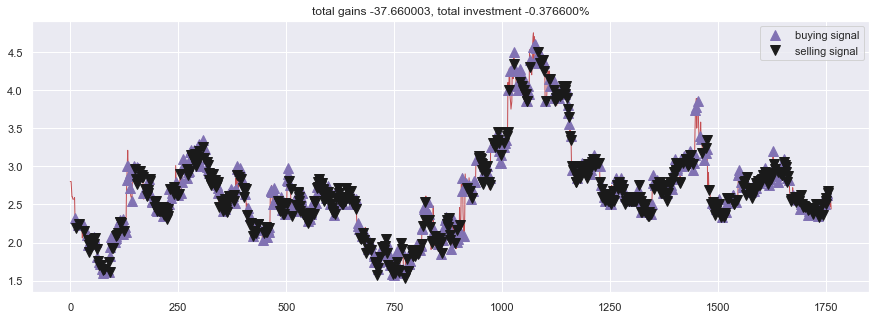

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=1)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()